The data set is comprised of 2,381 observations of 1 response/dependent variable (which indicates whether or not a mortgage application was denied) and 12 explanatory/independent variables.We are going to try to predict which variables have the biggest impact on the fact that a mortgage is denied or not in order to use the output of the model to identify potential instances of discrimination in the lending practices of the banks for which it is tasked with regulating.To do that we will  to construct and compare/contrast a series of K-Nearest Neighbor and Support Vector Machine models  that predict whether or not a given mortgage application is likely to be denied.

In [165]:
import pandas as pd 

In [166]:
#load the data 
df=pd.read_csv('https://raw.githubusercontent.com/sarahbismuth/m7DATA/master/M7_Data.csv')

#drop Unnamed: 0 column since it is not necessary 
df.drop(columns=['Unnamed: 0'],inplace=True)

In [167]:
df.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


# A dataframe containing :

dir:debt payments to total income ratio, a low ratio demonstrate a good balance between debt and income

hir:housing expenses to income ratio , the lower the better, usually should not exceed 28%

lvr:ratio of size of loan to assessed value of property the bigger the riskier

ccs:consumer credit score from 1 to 6 (a low value being a good score)

mcs:mortgage credit score from 1 to 4 (a low value being a good score)

pbcr:public bad credit record ?

dmi:denied mortgage insurance ?

self:self employed ?

single:is the applicant single ?

uria:1989 Massachusetts unemployment rate in the applicant's industry

condominium:is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package)
black:is the applicant black ?

deny:mortgage application denied ?

# EDA

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a283f7be0>,
      dtype=object)

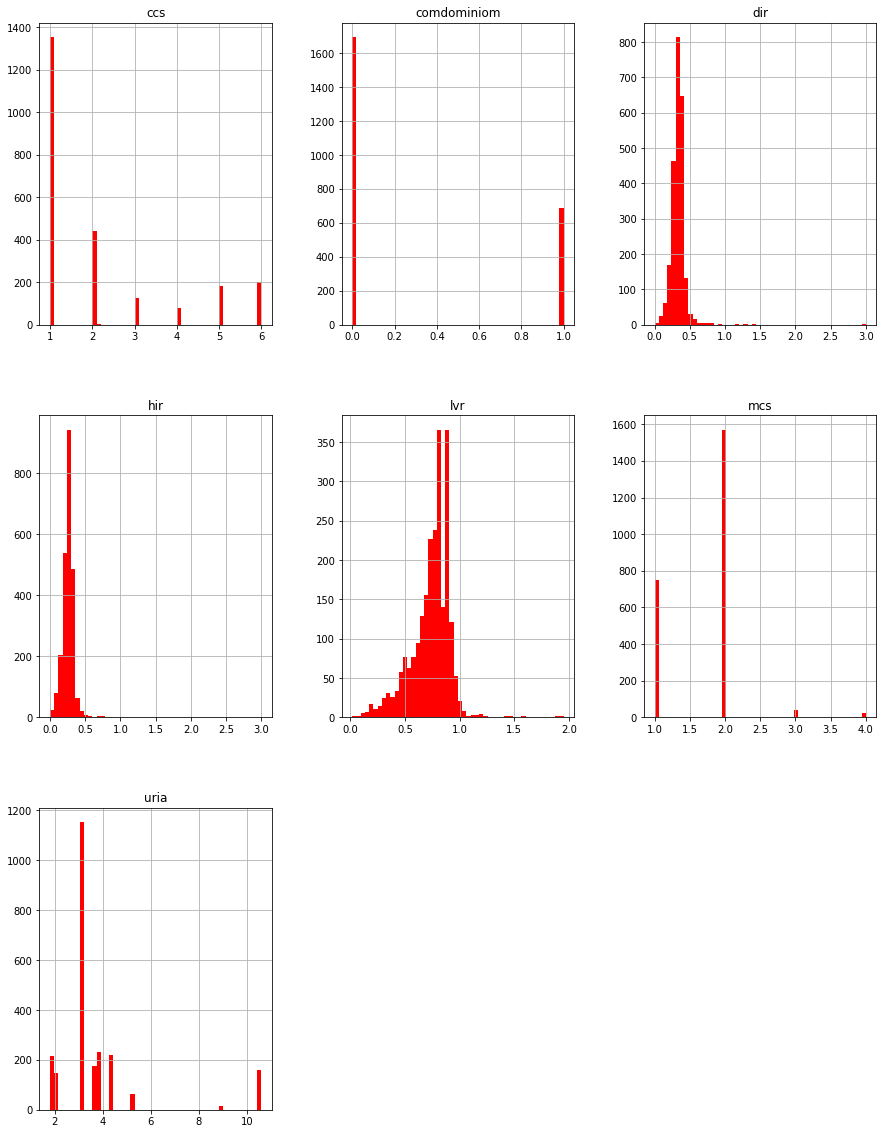

In [169]:
#Distribution of all the numerical  variables of the DataFrame
df.hist(figsize=(15,20),bins=50,color='red')

From this we can see that consumer credit score is mostly 1(smallest score possibility)  which is a good thing since it is said that a low score is a good score.
Concerning the dir, which is the debt payments to total income ratio, we can see that the distribution is mostly between 0 and 0.5, with the  highest  being less than 0.5.This is good indicator since a low ratio demonstrates a good balance between debt and income.
For hir most of the values are also distributed between 0 and 0.5,here the lower the ratio the better is it. Moreover,usually it should not exceed 0.28,most of the values seem not to exceed it.

lvr is left skewed,most of the values are between 0 and 1 with the greater pic being before 1, this corresponds to the domain knowledge since we know that the bigger this ratio the riskier it is and that usually for mortgage this value does not exceed 0.8.

For mcs most of the people have a score of 2, this seems realistics since the score are value from 1 to 4 and a low value is a good score. 

Finally, for uria, most of the applicant's industry  unemployment rate in 1989  in Massachusetts was 3, which is relatively low since we generally  consider that a rate lower than 5 is low.

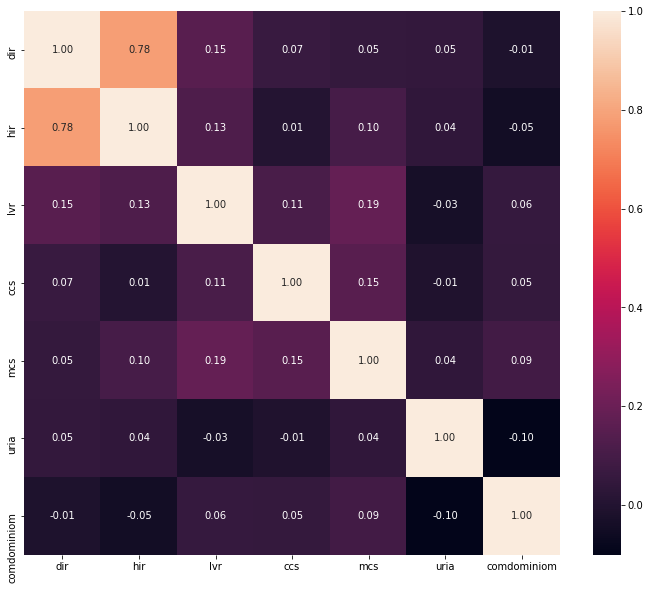

In [170]:
#correlation matrix heatmap
corrMatrix = df.corr()
plt.figure(figsize=( 12,10))
sns.heatmap(corrMatrix,annot=True,fmt=".2f")

From the corr matrix we can see that most of the variable are not highly correlated, except hir and dir that with a correlation of 0.78 have a high positive correlation.


The following bar plots are here to understand the frequency of deny for each categorical variable.

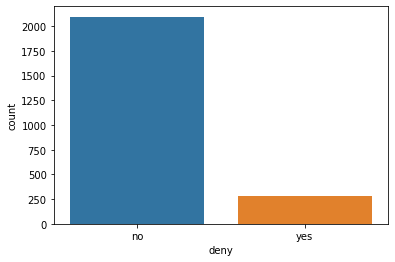

In [171]:
#deny bar plot 
sns.countplot(data = df, x = 'deny')

We can see that most of the mortgage are not deny, thus we have an unbalanced variable. 


Text(0, 0.5, 'Frequency')

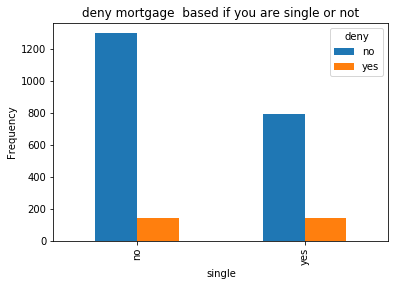

In [172]:
# barplot of single  grouped by deny (Yes or NO)
pd.crosstab(df.single, df.deny).plot(kind='bar')
plt.title('deny mortgage  based if you are single or not')
plt.xlabel('single')
plt.ylabel('Frequency')

From that we can see that even if there is more no deny mortgage for people that are not single, the frequency of deny mortgage is similar for people that are single and those who are not.

Text(0, 0.5, 'Frequency')

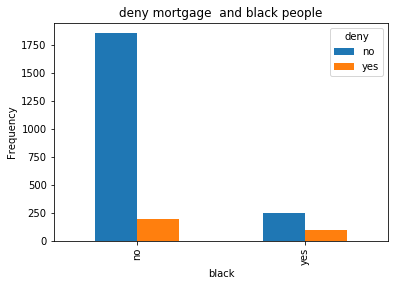

In [173]:
# barplot of black people  grouped by deny (Yes or NO)
pd.crosstab(df.black, df.deny).plot(kind='bar')
plt.title('deny mortgage  and black people')
plt.xlabel('black')
plt.ylabel('Frequency')


We can see that there is a lot more black people that are asking for mortgage based on the number of mortgage deny and accepted that are much bigger for people that are not black.Also the fact of being black or not as no effect on your mortgage being deny or not 

Text(0, 0.5, 'Frequency')

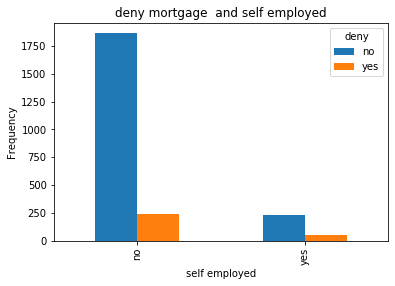

In [174]:
## barplot of self employed   grouped by deny (Yes or NO)
pd.crosstab(df.self, df.deny).plot(kind='bar')
plt.title('deny mortgage  and self employed')
plt.xlabel('self employed')
plt.ylabel('Frequency')



not being self employed since to decrease your chance a little to be deny 

Text(0, 0.5, 'Frequency')

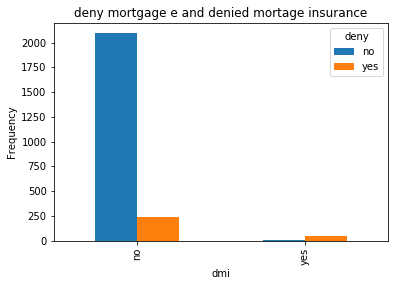

In [175]:
## barplot of dmi  grouped by deny (Yes or NO)
pd.crosstab(df.dmi, df.deny).plot(kind='bar')
plt.title('deny mortgage e and denied mortage insurance')
plt.xlabel('dmi')
plt.ylabel('Frequency')

We can see that most of the time people who have mortgage assurance will not see their mortgage to be denied

Text(0, 0.5, 'Frequency')

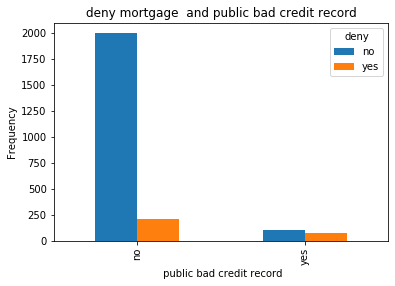

In [176]:
## barplot of pcbr grouped by deny (Yes or NO)
pd.crosstab(df.pbcr, df.deny).plot(kind='bar')
plt.title('deny mortgage  and public bad credit record')
plt.xlabel(' public bad credit record')
plt.ylabel('Frequency')

 # DATA PREPARATION

In [177]:
df.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

In [178]:
#proportion of the missing value in the dataframe 
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

dir            0.000000
hir            0.000000
lvr            0.000000
ccs            0.000000
mcs            0.000000
pbcr           0.041999
dmi            0.000000
self           0.041999
single         0.000000
uria           0.000000
comdominiom    0.000000
black          0.000000
deny           0.000000
dtype: float64

In [179]:
#remove missing value
#the proportion of missing value is very small, less than 1%, thus all the missing values are going to be replace by their mode
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [180]:
#check that my previous code worked 
df.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           0
dmi            0
self           0
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

In [181]:
len(df['lvr'].unique())

1538

In [182]:
#cut the number at 2 points after the coma 
df['lvr']=round(df['lvr'],2)

In [183]:
df['dir']=round(df['dir'],2)

In [184]:
df['hir']=round(df['hir'],2)

In [185]:
len(df['lvr'].unique())

111

As we can see after rounding the numbers, the number of unique values has changed and is much smaller

In [186]:
#for all the categorical values change yes as 1 and no as 0
dummy={'yes':1,'no':0}
df['pbcr']=df['pbcr'].apply(lambda x:dummy[x])
df['dmi']=df['dmi'].apply(lambda x:dummy[x])
df['self']=df['self'].apply(lambda x:dummy[x])
df['single']=df['single'].apply(lambda x:dummy[x])
df['black']=df['black'].apply(lambda x:dummy[x])
df['deny']=df['deny'].apply(lambda x:dummy[x])

In [187]:
#check that the previous code worked 
df['pbcr']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      1
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
2351    0
2352    0
2353    0
2354    0
2355    1
2356    0
2357    0
2358    0
2359    1
2360    0
2361    0
2362    0
2363    0
2364    0
2365    0
2366    0
2367    0
2368    0
2369    0
2370    0
2371    0
2372    0
2373    0
2374    0
2375    0
2376    0
2377    0
2378    1
2379    0
2380    0
Name: pbcr, Length: 2381, dtype: int64

In [188]:
#Normalization of the data (only the non binary variables) so they have the same scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scale_cols = ['lvr','dir','ccs','mcs','uria','hir']
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [189]:
df.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,0.073333,0.073333,0.404145,0.8,0.333333,0,0,0,0,0.238636,0,0,0
1,0.086667,0.086667,0.466321,0.2,0.333333,0,0,0,1,0.159091,0,0,0
2,0.123333,0.083333,0.466321,0.0,0.333333,0,0,0,0,0.159091,0,0,0
3,0.106667,0.083333,0.435233,0.0,0.333333,0,0,0,0,0.284091,0,0,0
4,0.120000,0.116667,0.300518,0.0,0.000000,0,0,0,0,0.159091,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29501a20>,
      dtype=object)

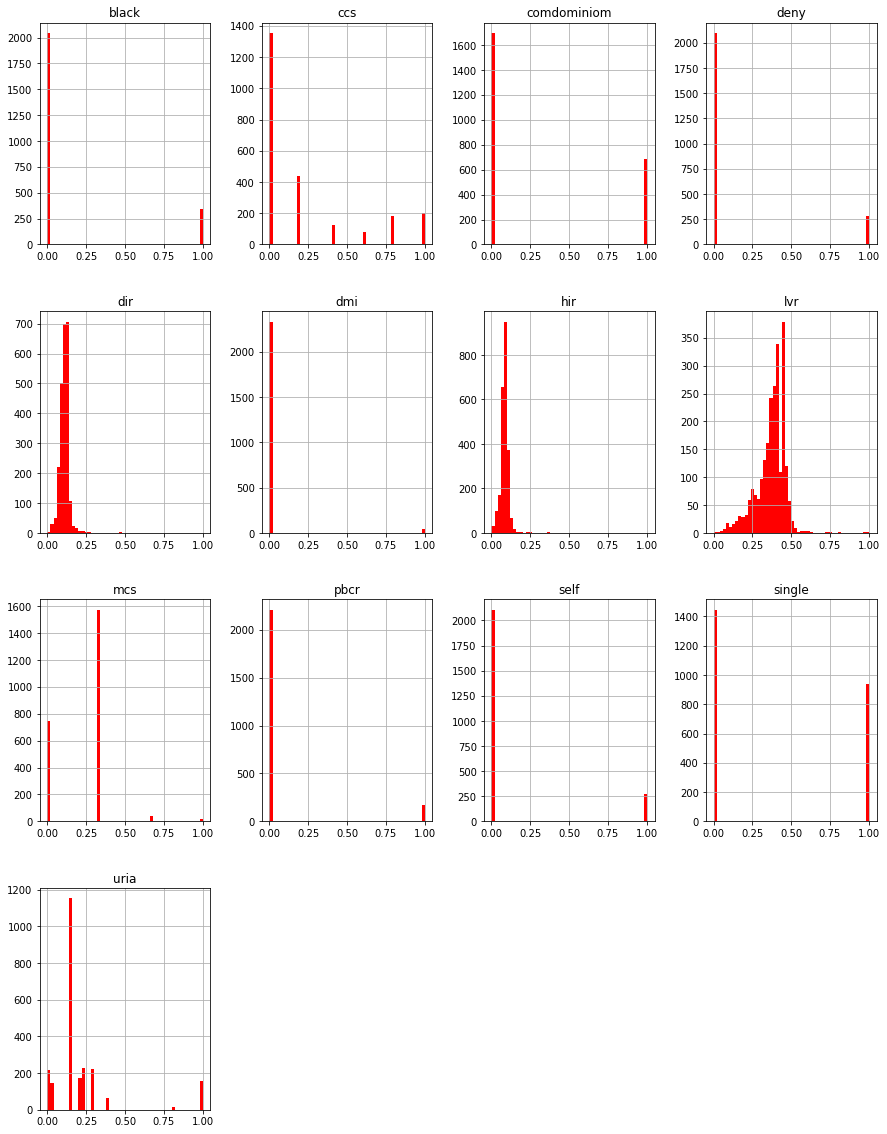

In [190]:
#Distribution of all the numerical  variables of the DataFrame
df.hist(figsize=(15,20),bins=50,color='red')

We can now see that all the varaibles are distributed on the same scale

# feature selection and dimensionality reduction

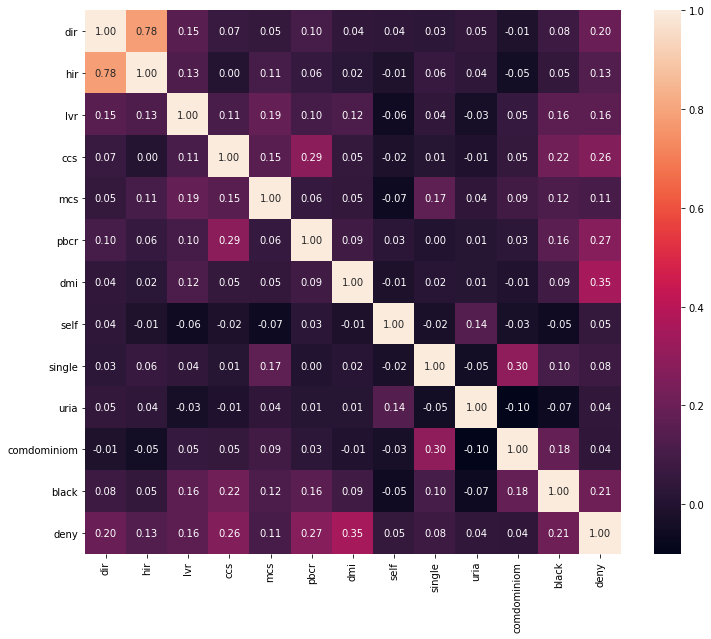

In [191]:
#correlation matrix heatmap
corrMatrix = df.corr()
plt.figure(figsize=( 12,10))
sns.heatmap(corrMatrix,annot=True,fmt=".2f")

Looking at the results of the correlation matrix and the calculation of the correlation of hir dir with deny , we can see that hir and dir are highly correlated between them. Thus,  we are not going to use these 2 colums at the same time.


/Users/sarahbismuth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sarahbismuth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


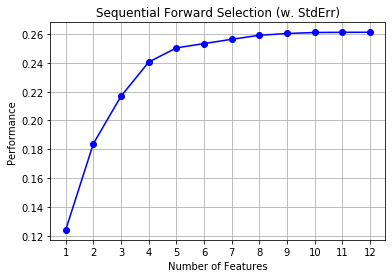

In [192]:
# to  go deeper into  which feature to use we apply forward selection 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
           k_features=12,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
X = df.drop(["deny"],1)
y = df['deny']
sfs.fit(X, y)
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()


As we can see in the graph after 8 features, the performance change is not significant, thus the use of  6 features seems to be a good choice.

/Users/sarahbismuth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sarahbismuth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('dir', 'lvr', 'ccs', 'pbcr', 'dmi', 'self', 'single', 'black')

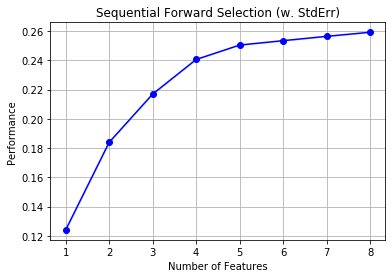

In [193]:
# the same forward selection code, but this time we are going to put  k_features=7 instead of 12, to see which are the 6 features we should keep
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
           k_features=8,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
X = df.drop(["deny"],1)
y = df['deny']
sfs.fit(X, y)
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
sfs.k_feature_names_

The 7 features to use are 'dir', 'ccs', 'pbcr', 'dmi', 'self', 'black','lvr','single'

# KNN and SVM models

In [194]:
#Train the data 
from sklearn.model_selection import train_test_split
X=df[['dir', 'lvr', 'ccs', 'pbcr', 'dmi', 'self', 'single', 'black']]
y=df['deny']
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)
X.head()

,dir,lvr,ccs,pbcr,dmi,self,single,black
0,0.073333,0.404145,0.8,0,0,0,0,0
1,0.086667,0.466321,0.2,0,0,0,1,0
2,0.123333,0.466321,0.0,0,0,0,0,0
3,0.106667,0.435233,0.0,0,0,0,0,0
4,0.120000,0.300518,0.0,0,0,0,0,0


In [195]:
#model 1 is all 8 features (x1)
#Model 2 (x2) removing self because it has a low correlation with deny, we want to see if it is important or not 
x1_train=x_train
x1_test=x_test


In [196]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [197]:
#this list all of the classifiers for KNN  and SVM that will be run on both models 
classifiers = [
    KNeighborsClassifier(n_neighbors = 5, p = 2, metric='minkowski'),
    KNeighborsClassifier(n_neighbors = 4, p = 2, metric='minkowski'),
    KNeighborsClassifier(n_neighbors = 6, p = 2, metric='minkowski'),
    KNeighborsClassifier(n_neighbors = 5, p = 1, metric='minkowski'),
    SVC(kernel="linear"),
    SVC(kernel = "rbf")
    ]
#this is training model 1
classifiers_fit1=[]
for i,classifier in enumerate(classifiers):
   
    classifiers_fit1.append(classifier.fit(x1_train,y_train))

In [198]:
#this function will allow to have all the metrics features of the different model in one table 
def results(my_list,test_set):
    results_df=pd.DataFrame()
    results_df['metric']=['accuracy','precision','f1','recall']
    for i,classifier in enumerate(my_list):
        predictor=classifier.predict(test_set)
        results_df[i+1] = [metrics.accuracy_score(y_test,predictor),metrics.precision_score(y_test,predictor),metrics.f1_score(y_test,predictor),metrics.recall_score(y_test,predictor)]
    print(results_df)
    

In [199]:
results(classifiers_fit1,x1_test)

      metric         1         2         3         4         5         6
0   accuracy  0.883916  0.890909  0.892308  0.885315  0.896503  0.902098
1  precision  0.571429  0.750000  0.703704  0.588235  0.937500  0.764706
2         f1  0.325203  0.277778  0.330435  0.327869  0.288462  0.426230
3     recall  0.227273  0.170455  0.215909  0.227273  0.170455  0.295455


Choice of the best KNN for model 1: 
1,2,3,4 represents the 3 differents KNN code where I change the parameters, in 1,2 and 3 I test 3 different neighbors. For number 4 I changed the distance measure from Euclidean(p=2)to Manhattan distance (p=1).
I have decided that i will keep the model number 3(p=2 and k=6) based on the highest  accuracy and recall that is higher in model 3 Than in model 2 (that has similar accuracy score).

Choice of the best SVM model:
The difference is in the fact that in number 5 we have kernel="linear" and in number 6 we have kernel = "rbf". For The comparison with model 2 I will keep number 6, since it has higher accuracy,f1 score and recall.

In [200]:
#Model 2 (x2) removing self  AND single because they have a very  low correlation with deny, we want to see if it is important or not
x2_train=x_train.drop(['self','single'],1)
x2_test=x_test.drop(['self','single'],1)

In [201]:
#this is training model 2
classifiers_fit2=[]
for i,classifier in enumerate(classifiers):
   
    classifiers_fit2.append(classifier.fit(x2_train,y_train))

In [202]:
results(classifiers_fit2,x2_test)

      metric         1         2         3         4         5         6
0   accuracy  0.897902  0.892308  0.896503  0.899301  0.896503  0.899301
1  precision  0.702703  0.703704  0.769231  0.710526  0.937500  0.710526
2         f1  0.416000  0.330435  0.350877  0.428571  0.288462  0.428571
3     recall  0.295455  0.215909  0.227273  0.306818  0.170455  0.306818


For model 2: I have done the same process i did in model 1.
For the KNN model, this time I have decided to choose number 4 which corresponds to k=5 and p=1, because it has the highest accuracy and highest F1 score.
For the SVM model I choose to keep number 6 for the same reasons stated in model 1.

# “best” classification model

In [205]:
#CROSS VALIDATION KNN MODEL 1
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors = 6)
# X,y will automatically devided by 6 folder, the scoring I will still use the accuracy
scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.88888889 0.89915966 0.88655462 0.9012605  0.8802521 ]
0.8912231559290383


In [208]:
#features i used for model 2
X2=X.drop(['self','single'],1)

In [209]:
#CROSS VALIDATION KNN MODEL 2
from sklearn.model_selection import cross_val_score
knn2 = KNeighborsClassifier(n_neighbors = 5)
# X,y will automatically devided by 6 folder, the scoring I will still use the accuracy
scores = cross_val_score(knn2, X2, y, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.89098532 0.91806723 0.8697479  0.90336134 0.89285714]
0.8950037876785935


In [215]:
#cross validation SVM model 1
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X, y, cv=5)

In [217]:
print(scores)
print(scores.mean())

[0.88888889 0.92436975 0.8907563  0.91176471 0.89285714]
0.9017273576097106


In [218]:
#cross validation SVM model 2
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X2, y, cv=5)
print(scores)
print(scores.mean())

[0.89098532 0.92226891 0.8907563  0.90756303 0.8907563 ]
0.900465972552543


I think that the best model is the SVM model for the second model. What justifies my toughness is the recall and the f1 scores that are very high.The accuracy of the 4 models are quite similar, thus i do not think that this should be a criterion to choose the best models.However we are trying to create a model that will reduce the discrimination of deny morgage.The recall score, that qualifies the number of correct positive prediction made out of all positive predictions that could have been made is 0.306818 for this model and is the highest of all the 4 models, same for the F1 score.
comparing this model to the regression in module 7 where accuracy was 0.90, Recall for deny 0.28 and f1 For recall 0.41, I Will still choose this model2 since the metric results seems better and more realistic.

In [220]:
#apply the model to the testing data
classifiers = [
    SVC(kernel = "rbf")
    ]
#this is testing 
classifiers_fit3=[]
for i,classifier in enumerate(classifiers):
   
    classifiers_fit3.append(classifier.fit(x2_test,y_test))

In [222]:
results(classifiers_fit3,x2_test)

      metric         1
0   accuracy  0.904895
1  precision  0.812500
2         f1  0.433333
3     recall  0.295455


The results of the metrics show that the model performs well to the testing data, since accuracy, precision,f1 AND Recall have hight results.

# Conclusion: 

I have conducted 4 different models 2 KNN and 2 SVM, where we tried to change the variables for instance we saw that changing the number of k had an impact on the results of the metrics.However from these 4 models i think that the second SVM model will conduct the best prediction for the bank.